# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



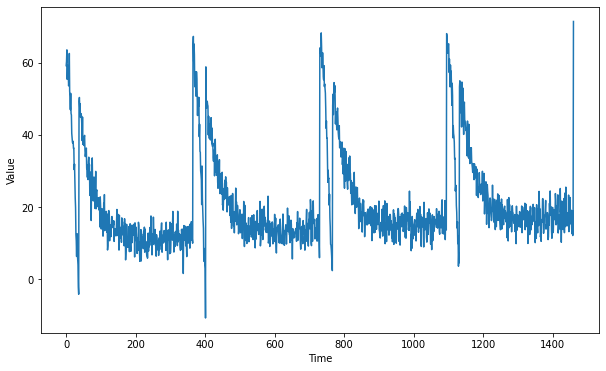

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below. 

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

### Another Method

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
# dataset = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # YOUR CODE HERE
                         input_shape=[None]), # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),# YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
rnn_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = rnn_model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 6s 53ms/step - loss: 22.6377 - mae: 23.1376 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 1s 40ms/step - loss: 22.6250 - mae: 23.1249 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 1s 37ms/step - loss: 22.6096 - mae: 23.1095 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 1s 40ms/step - loss: 22.5921 - mae: 23.0920 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 1s 39ms/step - loss: 22.5723 - mae: 23.0722 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 1s 37ms/step - loss: 22.5497 - mae: 23.0497 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 1s 38ms/step - loss: 22.5240 - mae: 23.0240 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 1s 38ms/step - loss: 22.4950 - mae: 22.9949 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 1s 38ms/step - loss: 22.4617 - mae:

34/34 [==============================] - 1s 39ms/step - loss: 4.8506 - mae: 5.3175 - lr: 3.5481e-05
Epoch 73/100
34/34 [==============================] - 1s 39ms/step - loss: 4.6818 - mae: 5.1485 - lr: 3.9811e-05
Epoch 74/100
34/34 [==============================] - 1s 39ms/step - loss: 4.6208 - mae: 5.0851 - lr: 4.4668e-05
Epoch 75/100
34/34 [==============================] - 1s 39ms/step - loss: 4.4928 - mae: 4.9548 - lr: 5.0119e-05
Epoch 76/100
34/34 [==============================] - 1s 39ms/step - loss: 4.4328 - mae: 4.8934 - lr: 5.6234e-05
Epoch 77/100
34/34 [==============================] - 1s 39ms/step - loss: 4.3698 - mae: 4.8339 - lr: 6.3096e-05
Epoch 78/100
34/34 [==============================] - 1s 40ms/step - loss: 4.4333 - mae: 4.8997 - lr: 7.0795e-05
Epoch 79/100
34/34 [==============================] - 1s 40ms/step - loss: 4.2000 - mae: 4.6618 - lr: 7.9433e-05
Epoch 80/100
34/34 [==============================] - 1s 40ms/step - loss: 4.3538 - mae: 4.8206 - lr: 8.9125e

In [10]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # YOUR CODE HERE
                         input_shape=[None]), # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),# YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
    ]) 
    
    ### END CODE HERE

    return model

In [11]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [12]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [13]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 6s 52ms/step - loss: 20.4073 - mae: 20.9073 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 39ms/step - loss: 19.2313 - mae: 19.7313 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 17.7091 - mae: 18.2088 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 40ms/step - loss: 16.1703 - mae: 16.6695 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 39ms/step - loss: 14.6646 - mae: 15.1632 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 37ms/step - loss: 13.2425 - mae: 13.7405 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 38ms/step - loss: 11.8909 - mae: 12.3881 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 41ms/step - loss: 10.5995 - mae: 11.0915 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 40ms/step - loss: 9.4224 - mae: 

Epoch 74/100
34/34 [==============================] - 1s 38ms/step - loss: 3.4863 - mae: 3.9517 - lr: 0.0045
Epoch 75/100
34/34 [==============================] - 1s 38ms/step - loss: 3.7902 - mae: 4.2635 - lr: 0.0050
Epoch 76/100
34/34 [==============================] - 1s 37ms/step - loss: 4.0883 - mae: 4.5595 - lr: 0.0056
Epoch 77/100
34/34 [==============================] - 1s 38ms/step - loss: 3.2460 - mae: 3.7132 - lr: 0.0063
Epoch 78/100
34/34 [==============================] - 1s 39ms/step - loss: 4.3146 - mae: 4.7872 - lr: 0.0071
Epoch 79/100
34/34 [==============================] - 1s 37ms/step - loss: 5.2277 - mae: 5.6966 - lr: 0.0079
Epoch 80/100
34/34 [==============================] - 1s 39ms/step - loss: 4.4696 - mae: 4.9414 - lr: 0.0089
Epoch 81/100
34/34 [==============================] - 1s 39ms/step - loss: 6.5977 - mae: 7.0776 - lr: 0.0100
Epoch 82/100
34/34 [==============================] - 1s 40ms/step - loss: 5.3305 - mae: 5.8035 - lr: 0.0112
Epoch 83/100
34/34 

(1e-08, 0.0001, 0.0, 30.0)

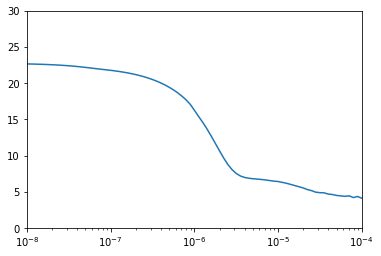

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

(1e-06, 1.0, 0.0, 30.0)

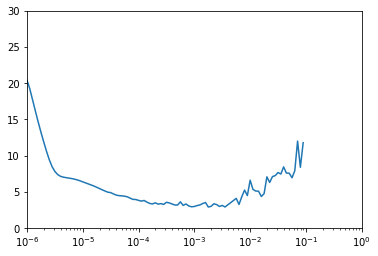

In [14]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [16]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [17]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 7s 53ms/step - loss: 22.6377 - mae: 23.1376
Epoch 2/50
34/34 [==============================] - 1s 40ms/step - loss: 22.6255 - mae: 23.1254
Epoch 3/50
34/34 [==============================] - 1s 39ms/step - loss: 22.6122 - mae: 23.1121
Epoch 4/50
34/34 [==============================] - 1s 39ms/step - loss: 22.5987 - mae: 23.0986
Epoch 5/50
34/34 [==============================] - 1s 39ms/step - loss: 22.5851 - mae: 23.0850
Epoch 6/50
34/34 [==============================] - 1s 37ms/step - loss: 22.5714 - mae: 23.0713
Epoch 7/50
34/34 [==============================] - 1s 38ms/step - loss: 22.5575 - mae: 23.0575
Epoch 8/50
34/34 [==============================] - 1s 39ms/step - loss: 22.5436 - mae: 23.0435
Epoch 9/50
34/34 [==============================] - 1s 39ms/step - loss: 22.5296 - mae: 23.0295
Epoch 10/50
34/34 [==============================] - 1s 38ms/step - loss: 22.5154 - mae: 23.0153
Epoch 11/50
34/34 [====================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [18]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

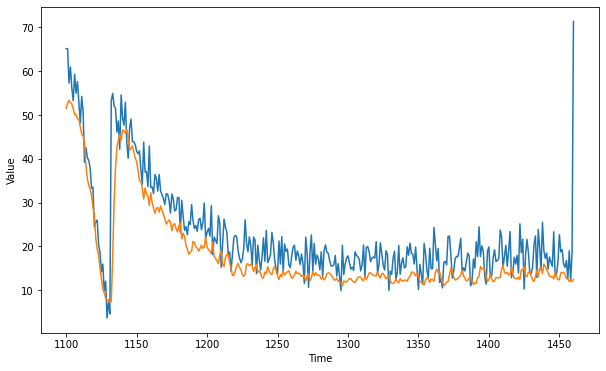

In [34]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(rnn_model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [35]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 50.28, mae: 4.99 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # YOUR CODE HERE
                      input_shape=[None]),# YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),# YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lstm_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"]) #(lr= PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = lstm_model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
34/34 [==============================] - 6s 54ms/step - loss: 1302.4675 - mae: 25.6230
Epoch 2/500
34/34 [==============================] - 1s 39ms/step - loss: 69.4917 - mae: 5.6699
Epoch 3/500
34/34 [==============================] - 1s 41ms/step - loss: 40.0241 - mae: 4.2486
Epoch 4/500
34/34 [==============================] - 1s 40ms/step - loss: 36.5019 - mae: 4.1739
Epoch 5/500
34/34 [==============================] - 1s 41ms/step - loss: 34.8600 - mae: 4.1268
Epoch 6/500
34/34 [==============================] - 1s 40ms/step - loss: 31.5229 - mae: 3.7010
Epoch 7/500
34/34 [==============================] - 1s 40ms/step - loss: 31.1016 - mae: 3.6580
Epoch 8/500
34/34 [==============================] - 1s 40ms/step - loss: 37.1440 - mae: 4.2195
Epoch 9/500
34/34 [==============================] - 1s 40ms/step - loss: 31.5310 - mae: 3.8362
Epoch 10/500
34/34 [==============================] - 1s 42ms/step - loss: 39.7889 - mae: 4.4636
Epoch 11/500
34/34 [================

34/34 [==============================] - 1s 41ms/step - loss: 24.5577 - mae: 3.2374
Epoch 86/500
34/34 [==============================] - 1s 42ms/step - loss: 23.2450 - mae: 3.1122
Epoch 87/500
34/34 [==============================] - 1s 41ms/step - loss: 23.4990 - mae: 3.1241
Epoch 88/500
34/34 [==============================] - 1s 40ms/step - loss: 24.5432 - mae: 3.3012
Epoch 89/500
34/34 [==============================] - 1s 40ms/step - loss: 24.6613 - mae: 3.2379
Epoch 90/500
34/34 [==============================] - 1s 41ms/step - loss: 22.4086 - mae: 3.0322
Epoch 91/500
34/34 [==============================] - 1s 40ms/step - loss: 24.8139 - mae: 3.2240
Epoch 92/500
34/34 [==============================] - 1s 41ms/step - loss: 23.0746 - mae: 3.0539
Epoch 93/500
34/34 [==============================] - 1s 42ms/step - loss: 28.8863 - mae: 3.6794
Epoch 94/500
34/34 [==============================] - 1s 39ms/step - loss: 24.7393 - mae: 3.2446
Epoch 95/500
34/34 [=======================

34/34 [==============================] - 1s 39ms/step - loss: 21.7277 - mae: 2.9347
Epoch 169/500
34/34 [==============================] - 1s 39ms/step - loss: 22.9226 - mae: 3.0653
Epoch 170/500
34/34 [==============================] - 1s 38ms/step - loss: 21.7196 - mae: 2.9977
Epoch 171/500
34/34 [==============================] - 1s 37ms/step - loss: 23.9780 - mae: 3.2163
Epoch 172/500
34/34 [==============================] - 1s 38ms/step - loss: 21.5447 - mae: 2.9748
Epoch 173/500
34/34 [==============================] - 1s 40ms/step - loss: 22.5680 - mae: 3.0585
Epoch 174/500
34/34 [==============================] - 1s 40ms/step - loss: 24.1243 - mae: 3.1713
Epoch 175/500
34/34 [==============================] - 1s 41ms/step - loss: 23.3660 - mae: 3.1971
Epoch 176/500
34/34 [==============================] - 1s 40ms/step - loss: 23.6005 - mae: 3.1674
Epoch 177/500
34/34 [==============================] - 1s 40ms/step - loss: 21.8193 - mae: 3.0004
Epoch 178/500
34/34 [=============

34/34 [==============================] - 1s 40ms/step - loss: 21.6874 - mae: 2.9545
Epoch 252/500
34/34 [==============================] - 1s 41ms/step - loss: 21.2552 - mae: 2.9561
Epoch 253/500
34/34 [==============================] - 1s 42ms/step - loss: 20.7651 - mae: 2.8733
Epoch 254/500
34/34 [==============================] - 1s 42ms/step - loss: 21.2206 - mae: 2.9112
Epoch 255/500
34/34 [==============================] - 1s 40ms/step - loss: 21.1777 - mae: 2.8882
Epoch 256/500
34/34 [==============================] - 1s 41ms/step - loss: 21.9013 - mae: 3.0100
Epoch 257/500
34/34 [==============================] - 1s 43ms/step - loss: 21.6254 - mae: 2.9657
Epoch 258/500
34/34 [==============================] - 1s 42ms/step - loss: 22.7027 - mae: 3.0953
Epoch 259/500
34/34 [==============================] - 1s 42ms/step - loss: 22.7062 - mae: 3.0871
Epoch 260/500
34/34 [==============================] - 1s 40ms/step - loss: 22.4564 - mae: 3.0723
Epoch 261/500
34/34 [=============

34/34 [==============================] - 1s 40ms/step - loss: 22.0613 - mae: 3.1086
Epoch 335/500
34/34 [==============================] - 1s 42ms/step - loss: 20.5657 - mae: 2.8629
Epoch 336/500
34/34 [==============================] - 1s 39ms/step - loss: 21.9392 - mae: 2.9984
Epoch 337/500
34/34 [==============================] - 1s 40ms/step - loss: 22.1042 - mae: 3.0156
Epoch 338/500
34/34 [==============================] - 1s 42ms/step - loss: 25.0733 - mae: 3.3431
Epoch 339/500
34/34 [==============================] - 1s 40ms/step - loss: 20.6360 - mae: 2.8361
Epoch 340/500
34/34 [==============================] - 1s 41ms/step - loss: 22.0229 - mae: 3.0196
Epoch 341/500
34/34 [==============================] - 1s 39ms/step - loss: 21.4500 - mae: 2.9412
Epoch 342/500
34/34 [==============================] - 1s 39ms/step - loss: 21.5194 - mae: 2.9554
Epoch 343/500
34/34 [==============================] - 1s 40ms/step - loss: 20.2170 - mae: 2.8084
Epoch 344/500
34/34 [=============

34/34 [==============================] - 1s 40ms/step - loss: 20.3106 - mae: 2.8496
Epoch 418/500
34/34 [==============================] - 1s 40ms/step - loss: 22.1879 - mae: 3.0390
Epoch 419/500
34/34 [==============================] - 1s 40ms/step - loss: 23.5565 - mae: 3.2198
Epoch 420/500
34/34 [==============================] - 1s 40ms/step - loss: 21.1050 - mae: 2.9143
Epoch 421/500
34/34 [==============================] - 1s 42ms/step - loss: 20.7007 - mae: 2.9111
Epoch 422/500
34/34 [==============================] - 1s 40ms/step - loss: 21.4330 - mae: 3.0059
Epoch 423/500
34/34 [==============================] - 1s 40ms/step - loss: 21.9115 - mae: 3.0532
Epoch 424/500
34/34 [==============================] - 1s 40ms/step - loss: 20.8511 - mae: 2.9511
Epoch 425/500
34/34 [==============================] - 1s 40ms/step - loss: 20.3673 - mae: 2.8790
Epoch 426/500
34/34 [==============================] - 1s 41ms/step - loss: 20.6490 - mae: 2.8703
Epoch 427/500
34/34 [=============

34/34 [==============================] - 1s 41ms/step - loss: 20.9483 - mae: 2.9475


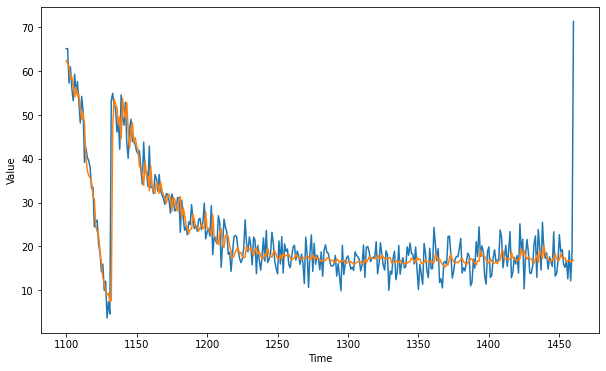

In [37]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(lstm_model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
lstm_forecast = lstm_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, lstm_forecast)

In [39]:
mse, mae = compute_metrics(series_valid, lstm_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.19, mae: 3.02 for forecast


<Figure size 432x288 with 0 Axes>

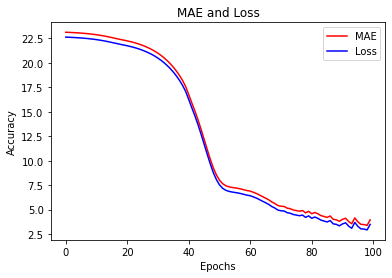

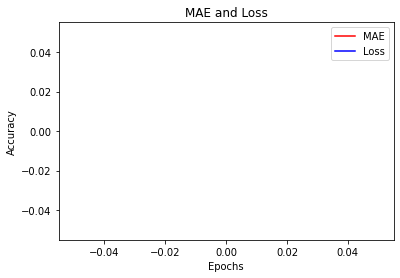

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**